# 2.5D Forward Simulation of DC Resistivity Data on a Tree Mesh

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** DC resistivity, forward simulation, apparent resistivity, tree mesh.

</br>

**Summary:** Here we use the module [SimPEG.electromagnetics.static.resistivity](myst:SimPEG#SimPEG.electromagnetics.static.resistivity) to simulate 2.5D DC resistivity data on a tree mesh. This approach is ideal when the local geology doesn't change along the strike direction, as we can leverage the symmetry of the problem to reduce computational cost.

</br>

**Learning Objectives:**

- How to define DC resistivity lines manually or by using utilities in SimPEG.
- How to design a tree mesh (or tensor mesh) for accurately simulating 2.5D DC resistivity data.
- How to define the Earth's electrical properties according to conductivity OR resistivity.
- How to included surface topography in the forward simulation.
- How to plot simulated data in pseudosection.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [SimPEG.electromagnetics.static.resistivity](myst:SimPEG#SimPEG.electromagnetics.static.resistivity).
We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). To simulate DC resistivity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import model_builder
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from SimPEG import maps, data
from SimPEG.electromagnetics.static.utils import static_utils, generate_dcip_sources_line

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
mpl.rcParams.update({"font.size": 14})

write_output = True # Optional

## Defining Topography

Generate surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray).
For the 2.5D simulation, topography is an (N, 2) [numpy.ndarray](myst:numpy#numpy.ndarray), where the first coordinate represent along-line position and the second coordinate represents the vertical position.

Here, we define a complete 3D topography, then extract the topography used for the 2.5D simulation via linear interpolation.
For user-specific simulations, you may load topography from an XYZ file.

In [2]:
# Define full 3D topography
x_topo, y_topo = np.meshgrid(
    np.linspace(-3000, 3000, 601), np.linspace(-3000, 3000, 101)
)
T = 800.
z_topo = 40.0 * np.sin(2 * np.pi * x_topo / T) - 40.0
z_topo[np.abs(x_topo) > T/2] = -40.0
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

In [3]:
# Interpolate to 2D topography
interp_fun = LinearNDInterpolator(topo_xyz[:, 0:2], topo_xyz[:, -1])
x_topo_2d = np.unique(x_topo)
y_topo_2d = np.zeros_like(x_topo_2d)
z_topo_2d = interp_fun(np.c_[x_topo_2d, y_topo_2d])
topo_2d = np.c_[x_topo_2d, z_topo_2d]

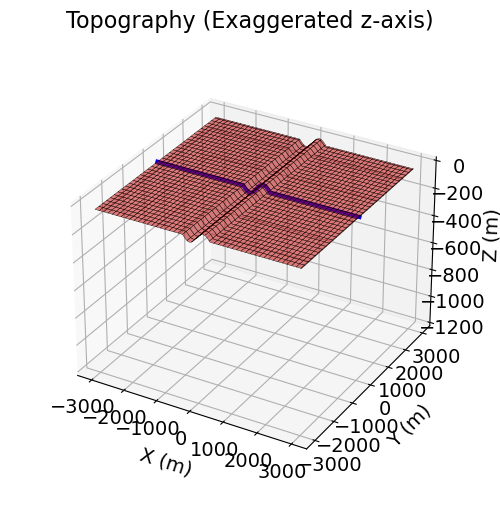

In [4]:
# Plot 3D topography and 2D topography line
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='3d')
ax.set_zlim([-1200, 0])
ax.plot_surface(
    x_topo, y_topo, z_topo, color='r', edgecolor='k', linewidth=0.25, alpha=0.5
)
ax.plot(x_topo_2d, y_topo_2d, z_topo_2d, color='b', linewidth=3)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel('X (m)', labelpad=10)
ax.set_ylabel('Y (m)', labelpad=10)
ax.set_zlabel('Z (m)', labelpad=10)
ax.set_title('Topography (Exaggerated z-axis)', fontsize=16, pad=-20)
ax.view_init(elev=30.)

## Defining the Survey

DC (and IP) surveys within SimPEG require the user to create and connect three types of objects:

- [receivers](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.receivers.BaseRx): which defines the locations of the potential (or MN) electrodes and the type of data; e.g. 'volt' for normalized voltage (V/A), 'apparent_resistivity' for apparent resistivity ($\Omega m$) or 'apparent_chargeability' for apparent chargeability (unitless). *Note only M electrode locations are needed to define pole receivers*.
- [sources](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.sources.BaseSrc): which defines the locations of the current (or AB) electrodes, and their associated receivers. *Note only A electrode locations are needed to define pole sources*.
- [survey](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.Survey): the object which stores and organizes all of the sources and receivers.

Each DC/IP datum corresponds to a unique pair of current and potential electrode locations. Within the SimPEG framework, there is a standard way in which the electrodes are organized. Because each current source (pole or dipole) is discretized to form a separate right-hand side for the DC resistivity PDE, each source object defines the electrodes for a single source. But for each source object, we can instantiate a single receiver object to store the electrode locations of all potential electrodes.

Using SimPEG, there are three approaches one might use to generate the a 2.5D resistivity survey. The final approach will be used to simulate the data for this tutorial.

**Option A: Define each source and its associated receivers directly**

For a 2.5D simulation, current electrode locations are defined as (2,) [numpy.array](myst:numpy#numpy.array) and the associated set of potential electrode locations are defined as (N, 2) [numpy.ndarray](myst:numpy#numpy.ndarray). We can define [Pole](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.sources.Pole) or [Dipole](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.sources.Dipole) sources. And we can define [Pole](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.receivers.Pole) or [Dipole](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.receivers.Dipole) receivers.

Here, the survey consists of an 800 m long EW dipole-dipole line with an electrode spacing of 40 m. There is a maximum of 10 potential electrodes per current electrode. And the data defined by the receivers are current-normalized voltages in **V/A**.

In [5]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "volt"
end_locations = np.r_[-400.0, 400.0]  # along-line position
station_separation = 40.0
num_rx_per_src = 10

In [6]:
# Define electrode locations
electrode_locations_x = np.arange(
    end_locations[0], end_locations[1]+station_separation, station_separation
)
electrode_locations_z = interp_fun(
    np.c_[electrode_locations_x, np.zeros_like(electrode_locations_x)]
)
electrode_locations = np.c_[electrode_locations_x, electrode_locations_z]

# Number of electrode locations
n_electrodes = len(electrode_locations_x)

In [7]:
# Instantiate empty list for sources
source_list = []

ii = 0
while ii < n_electrodes-3:
    
    # A and B electrode locations
    location_a = electrode_locations[ii, :]
    location_b = electrode_locations[ii+1, :]
    
    # M and N electrode locations
    ii_max = np.min([ii+3+num_rx_per_src, n_electrodes])
    locations_m = electrode_locations[ii+2:ii_max-1]
    locations_n = electrode_locations[ii+3:ii_max]
    
    # Define receivers for source ii
    receivers_list = [
        dc.receivers.Dipole(
            locations_m=locations_m, locations_n=locations_n, data_type=data_type
        )
    ]
    
    # Append source ii to list
    source_list.append(
        dc.sources.Dipole(receivers_list, location_a=location_a, location_b=location_b)
    )
    
    ii += 1

# Define survey
survey = dc.Survey(source_list)

**Option B: Survey from ABMN electrode locations**

If we have (N, 2) [numpy.ndarray](myst:numpy#numpy.ndarray) containing the A, B, M and N electrode locations for each datum (loaded or created), we can use the [generate_survey_from_abmn_locations](myst:SimPEG#SimPEG.electromagnetics.static.utils.generate_survey_from_abmn_locations) to generate the survey automatically.

**Option C: Survey from a set of survey lines**

If the survey is comprised of a single DC resistivity line, we can use the [generate_dcip_sources_line](myst:SimPEG#SimPEG.electromagnetics.static.utils.generate_dcip_sources_line) utility function to define the source list. I.e.:

```
# Generate source list for DC survey line
source_list = static_utils.generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

# Define survey
survey = dc.survey.Survey(source_list, survey_type=survey_type)
```

We can extract various objects and properties from the objects used to generate the survey. As we can see, all receivers associated with each source are defined within a single object.

In [8]:
print('# of locations: {}'.format(survey.nSrc))  # number of sources
print('# of data: {}'.format(survey.nD))         # number of data that will be simulated
print(survey.source_list[3])                     # the 3rd source object
print(survey.source_list[3].receiver_list[0])    # all its receivers

# of locations: 18
# of data: 135
Dipole(a: [-280.          -72.36067977]; b: [-240.          -78.04226065])
Dipole(m: [-200.  -80.]; n: [-160.          -78.04226065]),
Dipole(m: [-160.          -78.04226065]; n: [-120.          -72.36067977]),
Dipole(m: [-120.          -72.36067977]; n: [-80.         -63.51141009]),
Dipole(m: [-80.         -63.51141009]; n: [-40.         -52.36067977]),
Dipole(m: [-40.         -52.36067977]; n: [  0. -40.]),
Dipole(m: [  0. -40.]; n: [ 40.         -27.63932023]),
Dipole(m: [ 40.         -27.63932023]; n: [ 80.         -16.48858991]),
Dipole(m: [ 80.         -16.48858991]; n: [120.          -7.63932023]),
Dipole(m: [120.          -7.63932023]; n: [160.          -1.95773935]),
Dipole(m: [160.          -1.95773935]; n: [200.   0.])


Here we plot the electrode locations. We use the [pseudo_locations](myst:SimPEG#SimPEG.electromagnetics.static.utils.pseudo_locations) utility to extract the pseudo-locations.

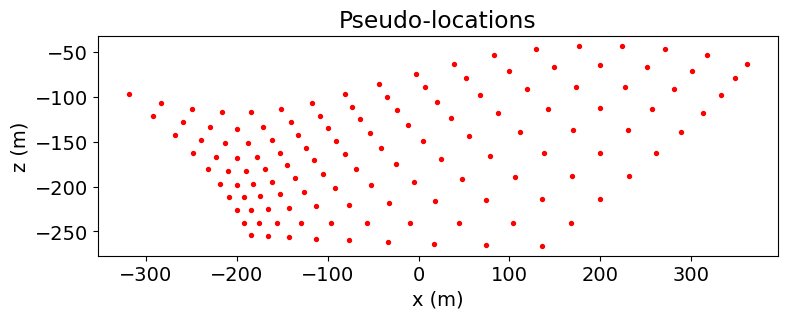

In [9]:
pseudo_locations = static_utils.pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations[:, 0], pseudo_locations[:, -1], 8, 'r')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Pseudo-locations')
plt.show()

## Designing a (Tree) Mesh

Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tree mesh](myst:discretize#discretize.TreeMesh). Because of the modular nature of SimPEG, you could define a [tensor mesh](myst:discretize#discretize.TensorMesh) instead.

**Standard approach:** The electric potential produced by a current electrode falls off as $r^{-3}$. So smaller cells are needed near the current electrodes to model the fields accurately, and larger cells can be used away from the current electrodes where the fields are smooth. Tree meshes are well-suited for DC (and IP) simulation because the cell size can be increased at specified distances from the current electrodes. For DC resistivity meshing, we advise the following considerations and rules of thumb:

1. Because there are no currents in the air, we do not need to pad upwards. I.e. the top of the mesh corresponds to the top of the topography.
2. We require at least 2-3 cells between each current electrode; with more accurate results being obtained when the minimum cell size is smaller. For a 2.D problem geometry, we can discretize much finer.
3. To be safe, the padding thickness should be at least 2-3 times the largest electrode spacing. 
4. The increase in cell size at increasing distancee from the current electrodes should not happen too abruptly. At each cell size, you should have a layer at least 4 cells thick before increasing the cell size.
5. Finer discretization is required when topography is significant.

**Tutorial mesh:** Here, a minimum cell width of 4 m (or 1/10 the minimum electrode spacing) is used within our survey region. The largest electrode spacing was 400 m, so a the padding was extended at least 1200 m from the survey region. Using the [refine_surface](myst:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](myst:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](myst:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [10]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d, padding_cells_by_level=[0, 0, 4, 4], finalize=False,
)

# Extract unique electrode locations.
unique_locations = survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

If desired, we can extract various properties of the mesh. E.g.

In [11]:
print('# of cells: {}'.format(mesh.n_cells))                  # Number of cells
print('# of x-faces: {}'.format(mesh.n_faces_x))              # Number of x-faces
print('Origin: {}'.format(mesh.origin))                       # bottom-southewest corner
print('Max cell volume: {}'.format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])                              # Cell center locations

# of cells: 12332
# of x-faces: 12303
Origin: [-2048. -2048.]
Max cell volume: 262144.0
[[-1792. -1792.]
 [-1280. -1792.]
 [-1792. -1280.]
 [-1280. -1280.]
 [ -768. -1792.]]


## Active Cells

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. Here, the discretize [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [12]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
ind_active = active_from_xyz(mesh, topo_2d)
nP = np.sum(ind_active)  # number of parameters

## Models and Mapping from the Model to the Mesh

In SimPEG, the term 'model' is not necessarily synonymous with the set of physical property values defined on the mesh. For example, the model may be defined as the logarithms of the physical property values, or be the parameters defining a layered Earth geometry. Models in SimPEG are 1D [numpy.ndarray](myst:numpy#numpy.ndarray) whose lengths are
equal to the number of model parameters.

Classes within the [SimPEG.maps](myst:SimPEG#SimPEG.maps.IdentityMap) module are used to define the mapping that connects the model to the physical property values used in the DC resistivity simulation. Sophisticated mappings can be defined by combining multiple mapping objects. But in the simplest case, the mapping is an identity map and the model consists of the conductivity/resistivity values for all mesh cells (including air).

When simulating DC resistivity data, we have the choice of using resistivity or conductivity to define the Earth's electrical properties. Here, we define the model and its associate mapping for two cases:
1. The model consists of the conductivity values for all active cells
2. The model consists of the log-resistivity values for all active cells

### Defining the Model

The units for resistivity are $\Omega m$ and the units for conductivity are $S/m$.

In [13]:
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [14]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(nP)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, -160.0], 60.0, mesh.cell_centers[ind_active, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, -100.0], 60.0, mesh.cell_centers[ind_active, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

# Define log-resistivity model
log_resistivity_model = np.log(1/conductivity_model)

### Defining the Mapping

For our first case, we use the [SimPEG.maps.InjectActiveCells](myst:SimPEG#SimPEG.maps.InjectActiveCells) mapping. This mapping projects quantities defined on the active cells to the entire mesh, and sets a constant value for all inactive cells. **Important:** we set all inactive (air) cells to 1e-8 S/m instead of 0. This is done to ensure that the linear system constructed to solve the PDE for the DC resistivity problem is well-conditioned.

For the second case, we both the [SimPEG.maps.InjectActiveCells](myst:SimPEG#SimPEG.maps.InjectActiveCells) and [SimPEG.maps.ExpMap](myst:SimPEG#SimPEG.maps.ExpMap) mappings; the latter of which takes the natural exponential. **Important:** we set all inactive (air) cells to 1e8 $\Omega m$ instead of $\infty$. Once again, this is done to ensure that the linear system constructed to solve the PDE for the DC resistivity problem is well-conditioned.

In [15]:
# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Resistivity map. Model parameters are log-resistivities for all active cells.
log_resistivity_map = (
    maps.InjectActiveCells(mesh, ind_active, 1/air_conductivity) *
    maps.ExpMap(nP=nP)
)

### Plotting the conductivity model

To show the geometry of the problem, we plot the conductivity model using the [plot_slice](myst:discretize#discretize.TreeMesh.plot_slice) method.

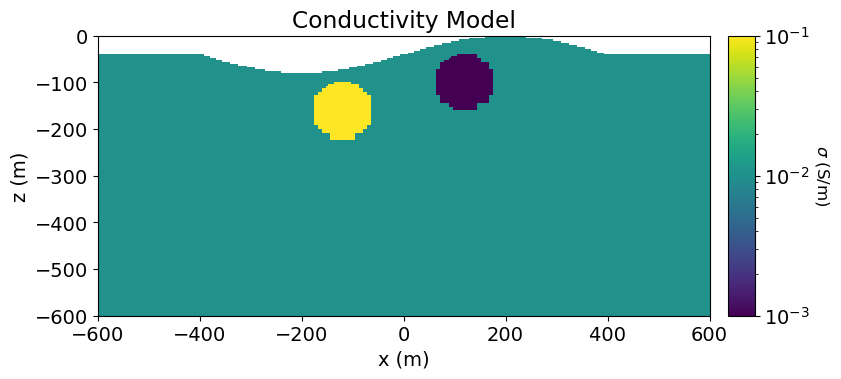

In [16]:
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1, grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.viridis}
)
ax1.set_xlim(-600, 600)
ax1.set_ylim(-600, 0)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

## Project Survey to Discretized Topography

Surface DC resistivity data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to simulating surface DC resistivity data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [17]:
survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

## Defining the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class. There are two simulation classes which may be used to simulate 2.5D DC resistivity data:

- [Simulation2DNodel](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.Simulation2DNodal), which defines the discrete electric potentials on mesh nodes.
- [Simulation2DCellCentered](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.Simulation2DCellCentered), which defines the discrete electric potentials at cell centers.

For surface DC resistivity data, the nodal formulation is more well-suited and will be used here. The cell-centered formulation works well for simulating borehole DC resistivity data. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- the mapping from the model to the mesh

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Here, we define two simulation objects, one where the model defines the subsurface conductivities, and one where the model defines subsurface log-resistivities. When our model is used to define subsurface electric conductivity, the mapping is set using the ``sigmaMap`` keyword argument. However when our model is used to define subsurface electric resistivity, the mapping must be set using the ``rhoMap`` keyword argument

In [18]:
# DC simulation for a conductivity model
simulation_con = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map
)

# DC simulation for a log-resistivity model
simulation_res = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=log_resistivity_map
)

## Predict DC Resistivity Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](myst:SimPEG#SimPEG.simulation.BaseSimulation.dpred) method. Note that despite the difference in how we defined the models representing the Earth's electrical properties, the data predicted by both simulations is equivalent.

In [19]:
dpred_con = simulation_con.dpred(conductivity_model)

d:\documents\repositories\simpeg\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
d:\documents\repositories\simpeg\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


In [20]:
dpred_res = simulation_res.dpred(log_resistivity_model)

In [21]:
print('MAX ABSOLUTE ERROR = {}'.format(np.max(np.abs(dpred_con-dpred_res))))

MAX ABSOLUTE ERROR = 3.3861802251067274e-15


## Plot DC Data in Pseudosection

Here we use the [plot_pseudosection](SimPEG#SimPEG.electromagnetics.static.utils.plot_pseudosection) utility function to represent the predicted data on a pseudosection plot as apparent conductivities. Since our receivers were defined to simulate data as normalized voltages, we use the [apparent_resistivity_from_voltage](SimPEG#SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function to convert the data to apparent resistivities, then take the reciprocal to obtain apparent conductivities.

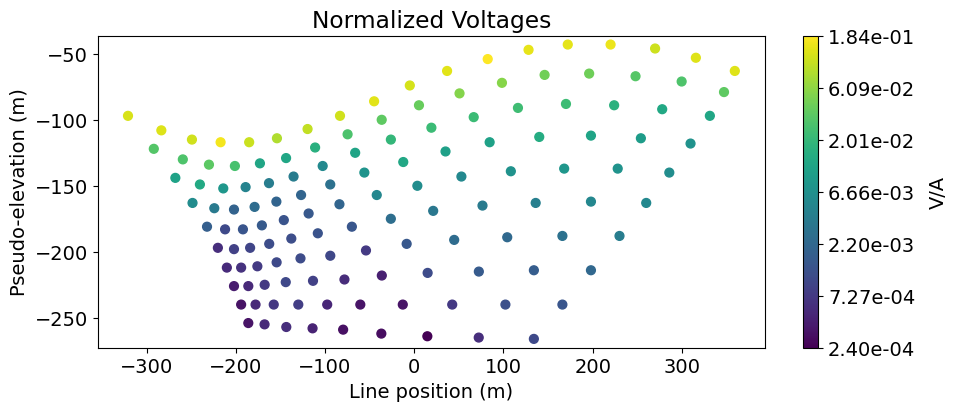

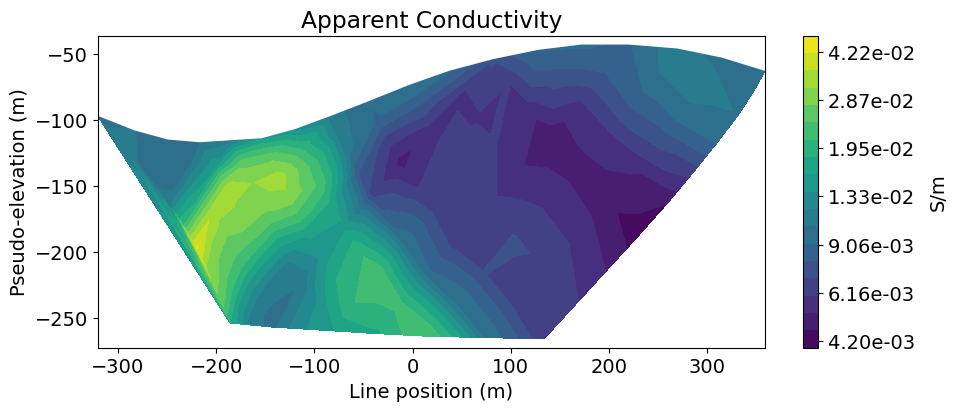

In [22]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
static_utils.plot_pseudosection(
    survey,
    dobs=np.abs(dpred_con),
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_conductivities = 1 / static_utils.apparent_resistivity_from_voltage(
    survey, dpred_con
)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
static_utils.plot_pseudosection(
    survey,
    dobs=apparent_conductivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.viridis},
)
ax1.set_title("Apparent Conductivity")
plt.show()

## Optional: Write out dpred

Write DC resistivity data, topography and true model




In [23]:
if write_output:
    
    dir_path = os.path.sep.join(['.', 'fwd_dcr_2d']) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # Add 5% Gaussian noise to each datum
    np.random.seed(225)
    std = 0.05 * np.abs(dpred_con)
    dc_noise = std * np.random.normal(size=len(dpred_con))
    dobs = dpred_con + dc_noise

    # Create a survey with the original electrode locations
    # and not the shifted ones
    # Generate source list for DC survey line
    source_list = generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations,
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )
    survey_original = dc.survey.Survey(source_list)

    # Write out data at their original electrode locations (not shifted)
    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)
    fname = dir_path + "dc_data.obs"
    write_dcip2d_ubc(fname, data_obj, "volt", "dobs")

    fname = dir_path + "topo_xyz.txt"
    np.savetxt(fname, topo_xyz, fmt="%.4e")